## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import xgboost as xgb
from pathlib import Path

In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, recall_score, precision_score, roc_curve, auc, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import joblib

## Setting Path & Settings

In [3]:
# suppress scientific notation by setting float_format
# pd.options.display.float_format = '{:.0f}'.format

In [4]:
model_results_path = Path("./model_results")
pkl_path = model_results_path / Path("pkl")

## Helper Functions

In [5]:
def generate_ROC_curve(y_test, y_pred):
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
model_performance_metrics = {}
def generate_results(y_test,y_pred, display=False): 
    # computes and stores various model results in a dictionary
    model_results_dict = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC Score": roc_auc_score(y_test, y_pred), 
        "Specificity": recall_score(y_test, y_pred, pos_label=0), 
        "Sensitivity": recall_score(y_test, y_pred, pos_label=1), 
        "True Positive": confusion_matrix(y_test, y_pred)[0][0], 
        "False Positive": confusion_matrix(y_test, y_pred)[0][1],
        "False Negative": confusion_matrix(y_test, y_pred)[1][0],
        "True Negative": confusion_matrix(y_test, y_pred)[1][0],
    }
    
    if display:
        for metric, value in model_results_dict.items():
            print(f"{metric}: {value}")
    
    return model_results_dict

In [7]:
def generate_pkl(model, path):
    # Exporting to Pkl File
    with open(path, 'wb') as f:
        pkl.dump(model, f)

    print(f"Model exported successfully to {path}")

In [8]:
def predict_from_pkl(pkl_path,new_record=None,X_test=None, scaler=None):
    with open(pkl_path, 'rb') as f:
        # Load the model from file
        loaded_model = pkl.load(f)
        if new_record:
            # Sorts the record alphabetically and convert to a df
            new_record = dict(sorted(new_record.items()))
            new_record_df = pd.DataFrame([list(new_record.values())], columns=list(new_record.keys()))
            # Apply the Scaler used for the model
            if scaler:
                new_record_scaled = scaler.transform(new_record_df)
                new_record_df = pd.DataFrame(list(new_record_scaled)[0]).transpose()
                new_record_df.columns = list(new_record.keys())
            # Make a prediction
            prediction = loaded_model.predict(new_record_df)[0]
        else:
            y_pred = loaded_model.predict(X_test)
            return y_pred
    
    if prediction == 1:
        return True
    else:
        return False

## Import Cleaned Dataset

In [9]:
bank_churn = pd.read_csv('./Cleaned_Modeling.csv')
bank_churn

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,...,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,last_transaction,days_since_last_transaction
0,1,2101,66,Male,0.0,self_employed,187.0,2,755,1458.71,...,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0,2023-05-21,321.0
1,5,2329,90,other,0.0,self_employed,1020.0,2,582,2291.91,...,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1,2023-08-06,244.0
2,6,1579,42,Male,2.0,self_employed,1494.0,3,388,927.72,...,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1,2023-11-03,155.0
3,7,1923,42,Female,0.0,self_employed,1096.0,2,1666,15202.20,...,13798.82,0.36,0.36,857.50,286.07,15719.44,15349.75,0,2023-11-01,157.0
4,8,2048,72,Male,0.0,retired,1020.0,1,1,7006.93,...,11232.37,0.64,0.64,1299.64,439.26,7076.06,7755.98,0,2023-09-24,195.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24403,30295,2398,42,Male,0.0,self_employed,146.0,2,286,7493.69,...,3515.03,0.51,90.10,1103.20,1183.04,7956.03,7431.36,0,2023-11-04,154.0
24404,30297,2325,10,Female,0.0,student,1020.0,2,1207,1076.43,...,2787.70,0.30,0.30,0.30,0.30,1076.43,1076.43,0,2023-10-22,167.0
24405,30298,1537,34,Female,0.0,self_employed,1046.0,2,223,3844.10,...,3865.55,1.71,2.29,901.00,1014.07,3738.54,3690.32,0,2023-12-17,111.0
24406,30299,2376,47,Male,0.0,salaried,1096.0,2,588,65511.97,...,21925.81,4666.84,3883.06,168.23,71.80,61078.50,57564.24,1,2023-12-31,97.0


## Partition & Oversample Dataset

In [10]:
# Create your feature matrix X and target vector y
X = bank_churn.drop(columns=['churn', 'last_transaction', 'customer_id', 'gender', 'occupation'], axis=1)
y = bank_churn['churn']

In [11]:
X.describe()

,vintage,age,dependents,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,days_since_last_transaction
count,24408.000000,24408.000000,24408.000000,24408.000000,24408.000000,24408.000000,2.440800e+04,2.440800e+04,2.440800e+04,2.440800e+04,2.440800e+04,2.440800e+04,2.440800e+04,2.440800e+04,2.440800e+04,2.440800e+04,24408.000000
mean,2090.759505,48.301786,0.341282,797.302155,2.217797,928.552688,7.512532e+03,7.622790e+03,7.605444e+03,7.016962e+03,3.918491e+03,3.719198e+03,4.099436e+03,3.741680e+03,7.583273e+03,7.608911e+03,166.999631
std,272.824196,17.375798,0.999470,433.215729,0.667546,948.608465,4.382688e+04,4.373454e+04,4.281387e+04,3.688151e+04,8.307524e+04,3.192478e+04,5.596387e+04,2.600183e+04,4.319188e+04,4.362391e+04,88.349461
min,73.000000,1.000000,0.000000,0.000000,1.000000,1.000000,-5.503960e+03,-3.149570e+03,1.428690e+03,-1.650610e+04,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,-3.374180e+03,-5.171920e+03,97.000000
25%,1957.000000,36.000000,0.000000,409.000000,2.000000,175.000000,1.764715e+03,1.894793e+03,2.197390e+03,1.792720e+03,3.600000e-01,3.600000e-01,4.600000e-01,4.700000e-01,2.009153e+03,2.079275e+03,108.000000
50%,2153.000000,46.000000,0.000000,834.000000,2.000000,566.000000,3.317940e+03,3.411915e+03,3.591030e+03,3.359815e+03,6.900000e-01,1.080000e+00,1.821450e+02,1.964200e+02,3.495945e+03,3.506895e+03,127.000000
75%,2292.000000,60.000000,0.000000,1096.000000,3.000000,1438.250000,6.822055e+03,6.847745e+03,6.825153e+03,6.616315e+03,9.291100e+02,1.053025e+03,1.537790e+03,1.561650e+03,6.882685e+03,6.791235e+03,192.000000
max,2476.000000,90.000000,52.000000,1649.000000,3.000000,4782.000000,5.905904e+06,5.740439e+06,5.700290e+06,5.010170e+06,1.226985e+07,2.361808e+06,7.637857e+06,1.414168e+06,5.778185e+06,5.720144e+06,1923.000000


#### Partion the Dataset

In [12]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Index of X_test
X_test_unscaled = X_test.copy()

#### Oversample the Dataset
We are oversampling the dataset because we don't need to preserve the class probabilities in our predictions. This is because a False negative (misidentifying customer who is leaving as one who isn't leaving) is more expensive than a False Positive (misidentifying a customer who isn't planning to leave as leaving). By oversampling the dataset, we are priroritizing the reduction of False Negatives at the cost of False Positives. With more accurate data about the actual cost of a False Positive and False Negative, we can create a more accruate approach using custom error functions. 

In [14]:
# Define the oversampling method
sm = SMOTE(random_state=42)

# Apply oversampling only on the training data
X_train_os, y_train_res = sm.fit_resample(X_train, y_train)

#### Scale the Dataset

In [15]:
# Using a MinMax Scaler for the Data
scaler = MinMaxScaler()
df_train_scaled = scaler.fit_transform(X_train_os)
X_train_res = pd.DataFrame(df_train_scaled, columns=X.columns)
df_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(df_test_scaled, columns=X.columns)
X_test.index = X_test_unscaled.index

#### RandomForest for Feature Selection

In [16]:
# Get Top 10 features for Random Forest's
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
importances = rf.feature_importances_

feature_importances = pd.Series(rf.feature_importances_, index=X_train_res.columns).nlargest(10)
most_important_features = list(feature_importances.index)
most_important_features.sort()

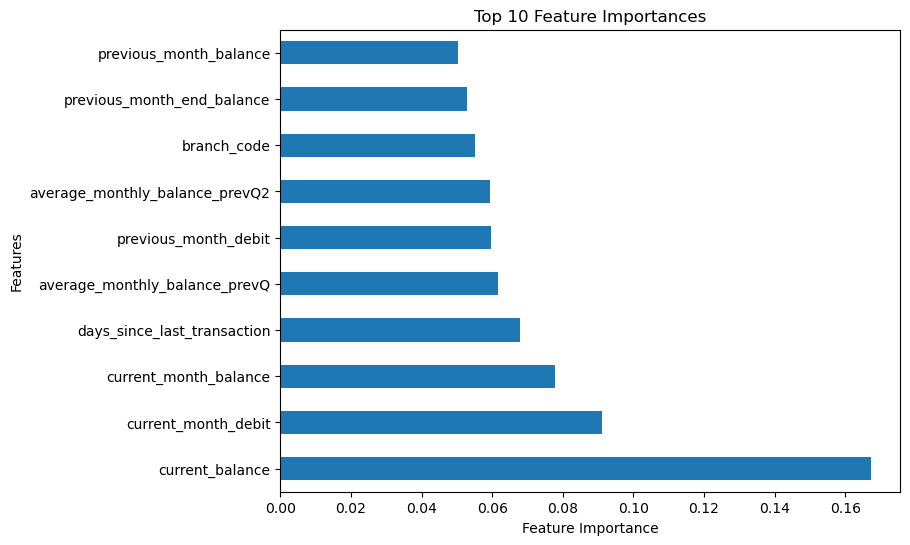

In [17]:
plt.figure(figsize=(8, 6))
feature_importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances')
plt.show()

In [18]:
# Filter the dataset to include only the top 10 features
X_train_res = X_train_res[most_important_features]
X_test = X_test[most_important_features]

## Building the Models

### Random Forest Models

In [19]:
# Define the parameter grid
param_grid = {
    'n_estimators': [300],
    'max_depth': [30],
    'min_samples_split': [2],
}

# Define the StratifiedKFold object
cv = StratifiedKFold(n_splits=5)

# Create the GridSearchCV object. For scoring, use aucpr
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model using the best parameters
rf = RandomForestClassifier(**best_params)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=30, n_estimators=300)

In [20]:
# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
model_performance_metrics["rf"] = generate_results(y_test, y_pred_rf, True)

Accuracy: 0.831421548545678
F1 Score: 0.5923724616146608
ROC AUC Score: 0.7541889258365365
Specificity: 0.8808857215576482
Sensitivity: 0.6274921301154249
True Positive: 3461
False Positive: 468
False Negative: 355
True Negative: 355


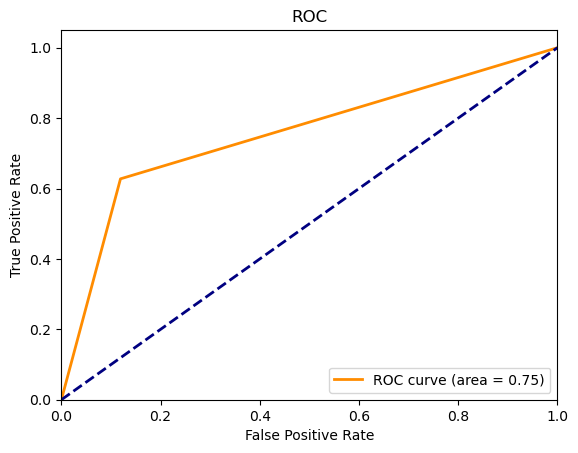

In [21]:
generate_ROC_curve(y_test, y_pred_rf)

In [22]:
generate_pkl(rf,pkl_path / Path("random_forest.pkl"))

Model exported successfully to model_results/pkl/random_forest.pkl


### ADA Boosting

In [23]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],          # Number of weak learners
    'learning_rate': [0.1, 0.5, 1.0]         # Learning rate
}

# Initialize AdaBoost classifier with base estimator
base_estimator = DecisionTreeClassifier()
adaboost_clf = AdaBoostClassifier(estimator=base_estimator, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(adaboost_clf, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Best Score: 0.7775719617802122


In [24]:
# Evaluate the model with the best parameters
best_estimator = grid_search.best_estimator_
y_pred_ada = best_estimator.predict(X_test)

In [25]:
# Evaluate the model
model_performance_metrics["ada"] = generate_results(y_test, y_pred_ada, True)

Accuracy: 0.7314625153625564
F1 Score: 0.45123482628714945
ROC AUC Score: 0.6686400022220222
Specificity: 0.7716976329854925
Sensitivity: 0.565582371458552
True Positive: 3032
False Positive: 897
False Negative: 414
True Negative: 414


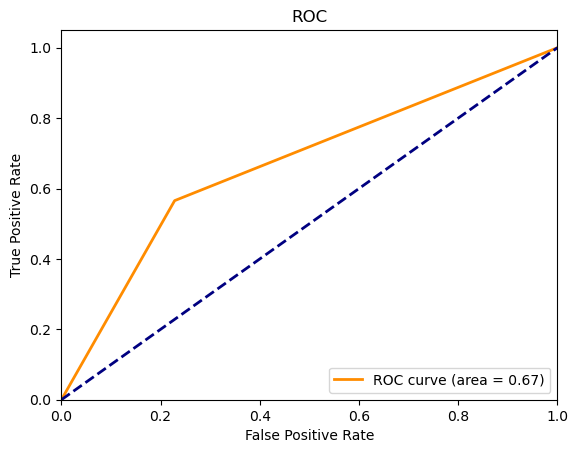

In [26]:
generate_ROC_curve(y_test, y_pred_ada)

In [27]:
generate_pkl(best_estimator,pkl_path/Path("ada_boost.pkl"))

Model exported successfully to model_results/pkl/ada_boost.pkl


### Logistic Regression

In [28]:
# Initialize the logistic regression model
logistic_reg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model to the training data
logistic_reg.fit(X_train_res, y_train_res)

# Make predictions on the testing data
y_pred_logit = logistic_reg.predict(X_test)

In [29]:
# Evaluate the model
model_performance_metrics["logit"] = generate_results(y_test, y_pred_logit, True)

Accuracy: 0.5921753379762392
F1 Score: 0.3752745528710386
ROC AUC Score: 0.6055505954725763
Specificity: 0.5836090608297276
Sensitivity: 0.6274921301154249
True Positive: 2293
False Positive: 1636
False Negative: 355
True Negative: 355


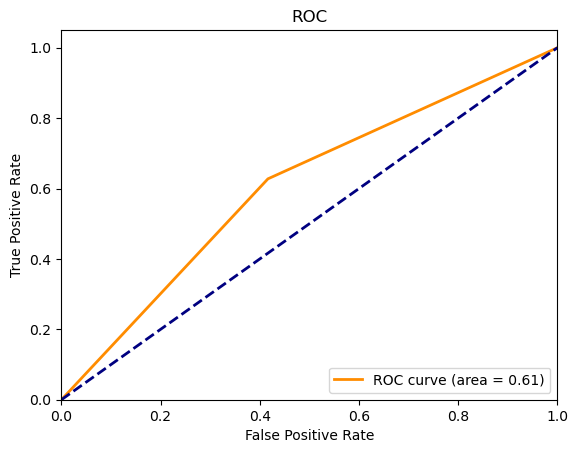

In [30]:
generate_ROC_curve(y_test, y_pred_logit)

In [31]:
generate_pkl(logistic_reg,pkl_path/Path("logit.pkl"))

Model exported successfully to model_results/pkl/logit.pkl


### XG Boosting

In [32]:
X_train_res.columns

Index(['average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2',
       'branch_code', 'current_balance', 'current_month_balance',
       'current_month_debit', 'days_since_last_transaction',
       'previous_month_balance', 'previous_month_debit',
       'previous_month_end_balance'],
      dtype='object')

In [33]:
# Initialize the XG Boost model 
xg_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
xg_model.fit(X_train_res, y_train_res)

# Make predictions
y_pred_XG = xg_model.predict(X_test)

In [34]:
# Evaluate the model
model_performance_metrics["xg"] = generate_results(y_test, y_pred_XG, True)

Accuracy: 0.8144203195411717
F1 Score: 0.5618955512572534
ROC AUC Score: 0.7368706395818538
Specificity: 0.8640875540850089
Sensitivity: 0.6096537250786989
True Positive: 3395
False Positive: 534
False Negative: 372
True Negative: 372


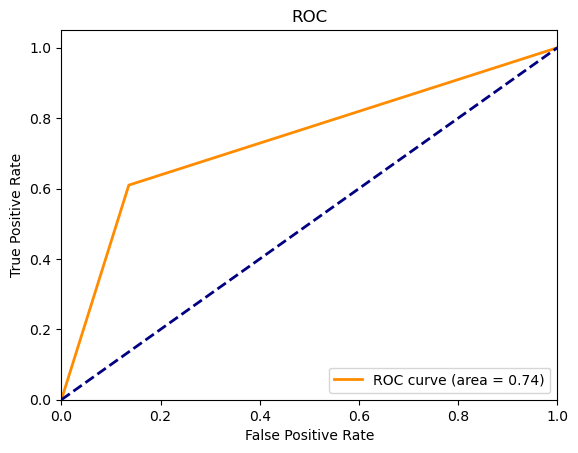

In [35]:
generate_ROC_curve(y_test, y_pred_XG)

In [36]:
generate_pkl(xg_model,pkl_path/Path("xg_model.pkl"))

Model exported successfully to model_results/pkl/xg_model.pkl


### Mixed Model

In [37]:
# Create results dataframe to find TP, TN, FN, and FP for test casing
results = pd.DataFrame(y_test)
results["ada"], results['logit'], results['rf'], results['xg'] = [y_pred_ada, y_pred_logit, y_pred_rf, y_pred_XG]
results

,churn,ada,logit,rf,xg
7356,0,0,0,0,0
10607,0,0,0,0,0
10877,0,0,1,0,0
17989,0,1,1,0,0
12461,0,0,1,0,0
...,...,...,...,...,...
17001,0,1,0,1,1
23588,0,1,0,1,1
15487,0,0,1,0,0
18568,0,0,1,0,0


In [38]:
# Define a function to find the most frequent value
def frequent_value(row):
    if row['pred_sum'] in [0, 1]:
        return 0
    elif row['pred_sum'] in [3, 4]:
        return 1
    else:  # For value 2
        return row['xg']


# Find Most Frequent Answer from all Models
results["pred_sum"] = results["ada"] + results['logit'] + results['rf'] + results['xg']
results["mixed_model"] = results.apply(frequent_value, axis=1)

In [39]:
# Evaluate the model
model_performance_metrics["mixed"] = generate_results(y_test, results["mixed_model"], True)

Accuracy: 0.8226136829168373
F1 Score: 0.5771484374999999
ROC AUC Score: 0.7459349946332288
Specificity: 0.8717230847543904
Sensitivity: 0.6201469045120671
True Positive: 3425
False Positive: 504
False Negative: 362
True Negative: 362


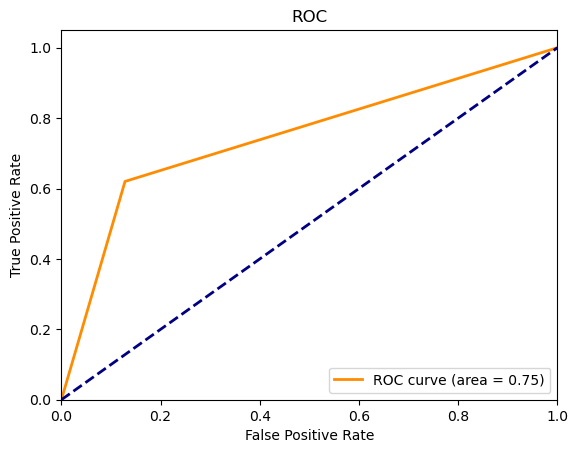

In [40]:
generate_ROC_curve(y_test, results["mixed_model"])

## Comparing Model Performance

In [41]:
model_performance_metrics_df = pd.DataFrame(model_performance_metrics)
round(model_performance_metrics_df,3)

,rf,ada,logit,xg,mixed
Accuracy,0.831,0.731,0.592,0.814,0.823
F1 Score,0.592,0.451,0.375,0.562,0.577
ROC AUC Score,0.754,0.669,0.606,0.737,0.746
Specificity,0.881,0.772,0.584,0.864,0.872
Sensitivity,0.627,0.566,0.627,0.610,0.620
True Positive,3461.000,3032.000,2293.000,3395.000,3425.000
False Positive,468.000,897.000,1636.000,534.000,504.000
False Negative,355.000,414.000,355.000,372.000,362.000
True Negative,355.000,414.000,355.000,372.000,362.000


In [42]:
model_performance_metrics_df.to_excel(model_results_path/Path("model_comparision_os+standardizing.xlsx"))

## Testing Pkl Files

In [43]:
sorted(most_important_features)

['average_monthly_balance_prevQ',
 'average_monthly_balance_prevQ2',
 'branch_code',
 'current_balance',
 'current_month_balance',
 'current_month_debit',
 'days_since_last_transaction',
 'previous_month_balance',
 'previous_month_debit',
 'previous_month_end_balance']

In [44]:
# Sample Input
sample_input = {
            'current_balance': 0.05,
            'current_month_debit': 0.05,
            'previous_month_debit': 0.05,
            'current_month_balance': 0.05,
            'average_monthly_balance_prevQ': 0.05,
            'previous_month_balance': 0.05,
            'previous_month_end_balance': 0.05,
            'average_monthly_balance_prevQ2': 0.05,
            'days_since_last_transaction': 0.05,
            'branch_code':20
}
sorted(sample_input.keys())

['average_monthly_balance_prevQ',
 'average_monthly_balance_prevQ2',
 'branch_code',
 'current_balance',
 'current_month_balance',
 'current_month_debit',
 'days_since_last_transaction',
 'previous_month_balance',
 'previous_month_debit',
 'previous_month_end_balance']

In [45]:
predict_from_pkl(pkl_path/Path("xg_model.pkl"),new_record=sample_input)

False

## Web App Support 

### Exporting Summaries to Min Max Inputs from Web App

In [46]:
# Need to find averages to help guide user for realistic values from dataset
feature_summary = X[most_important_features].describe()
feature_summary

,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,branch_code,current_balance,current_month_balance,current_month_debit,days_since_last_transaction,previous_month_balance,previous_month_debit,previous_month_end_balance
count,2.440800e+04,2.440800e+04,24408.000000,2.440800e+04,2.440800e+04,2.440800e+04,24408.000000,2.440800e+04,2.440800e+04,2.440800e+04
mean,7.605444e+03,7.016962e+03,928.552688,7.512532e+03,7.583273e+03,4.099436e+03,166.999631,7.608911e+03,3.741680e+03,7.622790e+03
std,4.281387e+04,3.688151e+04,948.608465,4.382688e+04,4.319188e+04,5.596387e+04,88.349461,4.362391e+04,2.600183e+04,4.373454e+04
min,1.428690e+03,-1.650610e+04,1.000000,-5.503960e+03,-3.374180e+03,1.000000e-02,97.000000,-5.171920e+03,1.000000e-02,-3.149570e+03
25%,2.197390e+03,1.792720e+03,175.000000,1.764715e+03,2.009153e+03,4.600000e-01,108.000000,2.079275e+03,4.700000e-01,1.894793e+03
50%,3.591030e+03,3.359815e+03,566.000000,3.317940e+03,3.495945e+03,1.821450e+02,127.000000,3.506895e+03,1.964200e+02,3.411915e+03
75%,6.825153e+03,6.616315e+03,1438.250000,6.822055e+03,6.882685e+03,1.537790e+03,192.000000,6.791235e+03,1.561650e+03,6.847745e+03
max,5.700290e+06,5.010170e+06,4782.000000,5.905904e+06,5.778185e+06,7.637857e+06,1923.000000,5.720144e+06,1.414168e+06,5.740439e+06


In [47]:
# Create results dataframe to find TP, TN, FN, and FP for test casing
results = pd.DataFrame(y_test)
results["ada"], results['logit'], results['rf'], results['xg'] = [y_pred_ada, y_pred_logit, y_pred_rf, y_pred_XG]
results

# Find TP
tp_only_df = results[results.sum(axis=1)==5]
tp_index = tp_only_df.sample().index[0]


# Find TN 
tn_only_df = results[results.sum(axis=1)==0]
tn_index = tn_only_df.sample().index[0]


# Find FP
fp_only_df = results[(results["churn"]==0) & (results.sum(axis=1)==4)]
fp_index = fp_only_df.sample().index[0]

# Find FN
fn_only_df = results[(results["churn"]==1) & (results.sum(axis=1)==1)]
fn_index = fn_only_df.sample().index[0]

In [48]:
# Adding features for default test sets in 
feature_summary = pd.concat([feature_summary,X_test_unscaled[most_important_features].\
                             loc[[tp_index,tn_index,fp_index,fn_index]]])
feature_summary.index = list(feature_summary.index[:8]) + ['TP','TN','FP','FN']
feature_summary

,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,branch_code,current_balance,current_month_balance,current_month_debit,days_since_last_transaction,previous_month_balance,previous_month_debit,previous_month_end_balance
count,2.440800e+04,2.440800e+04,24408.000000,2.440800e+04,2.440800e+04,2.440800e+04,24408.000000,2.440800e+04,2.440800e+04,2.440800e+04
mean,7.605444e+03,7.016962e+03,928.552688,7.512532e+03,7.583273e+03,4.099436e+03,166.999631,7.608911e+03,3.741680e+03,7.622790e+03
std,4.281387e+04,3.688151e+04,948.608465,4.382688e+04,4.319188e+04,5.596387e+04,88.349461,4.362391e+04,2.600183e+04,4.373454e+04
min,1.428690e+03,-1.650610e+04,1.000000,-5.503960e+03,-3.374180e+03,1.000000e-02,97.000000,-5.171920e+03,1.000000e-02,-3.149570e+03
25%,2.197390e+03,1.792720e+03,175.000000,1.764715e+03,2.009153e+03,4.600000e-01,108.000000,2.079275e+03,4.700000e-01,1.894793e+03
50%,3.591030e+03,3.359815e+03,566.000000,3.317940e+03,3.495945e+03,1.821450e+02,127.000000,3.506895e+03,1.964200e+02,3.411915e+03
75%,6.825153e+03,6.616315e+03,1438.250000,6.822055e+03,6.882685e+03,1.537790e+03,192.000000,6.791235e+03,1.561650e+03,6.847745e+03
max,5.700290e+06,5.010170e+06,4782.000000,5.905904e+06,5.778185e+06,7.637857e+06,1923.000000,5.720144e+06,1.414168e+06,5.740439e+06
TP,1.673880e+03,1.464370e+03,2804.000000,6.558900e+02,4.550950e+03,2.097159e+04,109.000000,1.647700e+02,5.167400e+02,1.275200e+02
TN,2.028650e+03,2.615180e+03,273.000000,1.672710e+03,1.790240e+03,2.000000e-01,196.000000,2.026120e+03,2.000000e-01,1.916170e+03


In [49]:
# export feature_summary file to excel
feature_summary.to_excel(model_results_path/Path("feature_summary.xlsx"))

In [61]:
feature_summary.transpose().to_dict()['TP']

{'average_monthly_balance_prevQ': 1673.88,
 'average_monthly_balance_prevQ2': 1464.37,
 'branch_code': 2804.0,
 'current_balance': 655.89,
 'current_month_balance': 4550.95,
 'current_month_debit': 20971.59,
 'days_since_last_transaction': 109.0,
 'previous_month_balance': 164.77,
 'previous_month_debit': 516.74,
 'previous_month_end_balance': 127.52}

### Creating a identical scaler (for relevant features) for Web App

In [54]:
# Using a MinMax Scaler for the Data
scaler_slice = MinMaxScaler()
scaler_slice.fit(X_train_os[most_important_features])
# Save for Use in WebApp
scaler_filename = "MinMaxScaler.save"
joblib.dump(scaler_slice, model_results_path/scaler_filename) 

['model_results/MinMaxScaler.save']